Read in all libraries

In [1]:
#all imports

import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import scipy
import scipy.stats as stats
import scipy.integrate
from scipy.stats import norm
from scipy.optimize import curve_fit
import scipy.stats as scs
from astropy.modeling import models, fitting

Define all required functions.
Note that I changed the rand_num_gen so that it will never return the first or last pixel

In [2]:
def rand_num_gen():
    #border: ln[3] was the original random_num_gen() 
    #border is the number of desired pixels/ number of required surrounding pixels based on electron cloud/ pixel length ratio
    photon_x = random.uniform(border*pix_L, ((num_pix_x - border) * pix_L)) #microns
    photon_y = random.uniform(border*pix_L, ((num_pix_x - border) * pix_L)) #microns
    return photon_x, photon_y

In [3]:
#def rand_num_gen():
#    photon_x = random.random() * (num_pix_x) * pix_L + pix_L #microns
#    photon_y = random.random() * (num_pix_y) * pix_L + pix_L #microns
#    return photon_x, photon_y

In [4]:
def find_closest_pix(photon_x, photon_y):
    closest_pix_x = (np.where(np.abs(detector_x - photon_x) == np.min(np.abs(detector_x - photon_x))))[0]
    closest_pix_x = closest_pix_x[0]
    closest_pix_y = (np.where(np.abs(detector_y - photon_y) == np.min(np.abs(detector_y - photon_y))))[0]
    closest_pix_y = closest_pix_y[0]
    return(closest_pix_x, closest_pix_y)

In [5]:
def ghost_cell():
    if closest_pix_x < math.floor(num_pix_plt / 2) or closest_pix_y < math.floor(num_pix_plt / 2) or closest_pix_x > (num_pix_x - math.floor(num_pix_plt / 2)) or closest_pix_y > (num_pix_y - math.floor(num_pix_plt / 2)):
        #xtr_)row/col is the number of rows or columns needed to fit the entire photon in the array
        #xtr_row = xtr_col = (math.ceil((e_cloud * (1/2)) / pix_L)) defined at top
        #redefine detector size to fit
        detector = np.zeros((num_pix_x + xtr_row*2, num_pix_y + xtr_col*2))
        detector_x = np.arange(num_pix_x + xtr_row) * pix_L + pix_half_L
        detector_y = np.arange(num_pix_y + xtr_col) * pix_L + pix_half_L
        return detector, detector_x, detector_y
        print('photon fell too close to edge of detector for the graph we wrote to work. Added extra layer of dead pixels to help?')
    else:
        print('no imshow problems')

In [6]:
def zero_ghost_cells():
    if closest_pix_x < math.floor(num_pix_plt / 2) or closest_pix_y < math.floor(num_pix_plt / 2) or closest_pix_x > (num_pix_x - math.floor(num_pix_plt / 2)) or closest_pix_y > (num_pix_y - math.floor(num_pix_plt / 2)):
        #they will be erased
        #xtr_row = xtr_col = 2 * (math.ceil((e_cloud * (1/2)) / pix_L)) defined at top
        detector[0:xtr_row,] = 0 #top
        detector[-xtr_row:,] = 0 #bottom
        detector[:,0:xtr_col] = 0 #left
        detector[:,-xtr_col:] = 0 #right
        print('photon fell too close to edge of detector. Brought ghost cell values to zero.')
        return detector
    else:
        print('didnt work')

In [7]:
def gaus_noise():
    #np.random.normal(mean noise, std dev, size of array)
    #had to make an if statement in case the array is larger for ghost cells
    #if closest_pix_x < math.floor(num_pix_plt / 2) or closest_pix_y < math.floor(num_pix_plt / 2) or closest_pix_x > (num_pix_x - math.floor(num_pix_plt / 2)) or closest_pix_y > (num_pix_y - math.floor(num_pix_plt / 2)):
    #    detector += np.random.normal(loc = mean, scale = std_dev, size = (num_pix_x + xtr_row * 2, num_pix_y + xtr_col *2))
    #else:
    #loc = mean
    noise_array = np.random.normal(loc = mean, scale = std_dev, size = (num_pix_x, num_pix_y))
    return noise_array

In [8]:
def integrate_setup():
#Whenever you see an error that include 'NoneType' that means that you have an operand or an object that is None when you were expecting something else.
#num_subpix is the number in x & y (rows and columns) they are always equal because the photon will always be a circle
    #subpix_x_cen, subpix_y_cen, subpix_z_cen, subpix_arr = integrate_setup()
    subpix_arr = np.zeros((num_subpix_x, num_subpix_y, num_subpix_z))
    subpix_x_cen = np.arange(num_subpix_x) * subpix_L + (detector_x[int(closest_pix_x - start_pix)] - pix_half_L) + subpix_L
    subpix_y_cen = np.arange(num_subpix_y) * subpix_L + (detector_y[int(closest_pix_y - start_pix)] - pix_half_L) + subpix_L  
    subpix_z_cen = np.arange(num_subpix_z) * subpix_L
    return subpix_arr, subpix_x_cen, subpix_y_cen, subpix_z_cen

In [9]:
#this can hypothitically done at the beginning (or anywhere before the plot really...)
#this function does not rely on any other functions -- it will also remain the same for the same pixel/e_cloud sizes
def find_num_pix_plt(num_pix_plt):
    if num_pix_plt % 2 == 0:
        num_pix_plt += 3
    else:
        num_pix_plt += 2
    return num_pix_plt

In [10]:
def sphere_integrate(subpix_x_cen, subpix_y_cen, subpix_z_cen):
    for i in range(num_subpix_x):
        for j in range(num_subpix_y):
            for k in range(num_subpix_z):
                dist_cen_photon = np.sqrt((subpix_x_cen[i] - photon_x)**2 + \
                                                (subpix_y_cen[j] - photon_y)**2 + \
                                                (subpix_z_cen[k] - photon_z)**2)
#the entire electron will be contained within a pixel if the distance from center of photon is less than half the e_cloud diameter
                if dist_cen_photon < e_cloud / 2:
                    subpix_arr[i,j,k] = 1
    return subpix_arr
#dist_cen_photon = sphere_integrate(subpix_x_cen, subpix_y_cen, subpix_z_cen)

In [11]:
def each_pix_e(closest_pix_x, closest_pix_y):
    for ii in range(int(closest_pix_x - start_pix), int(closest_pix_x + (num_pix_plt - start_pix))):
        for jj in range(int(closest_pix_y - start_pix), int(closest_pix_y + (num_pix_plt - start_pix))):
            left_edge = edge_x[ii]
            right_edge = edge_x[ii + 1] 
            bottom_edge = edge_y[jj]
            top_edge = edge_y[jj + 1] 
            #gives us 1st element to sum over
            #>= <= allows us to account for the pixels landing on the edge
            match_x0 = np.where (subpix_x_cen >= left_edge)[0][0]
            #[0][-1] -1 means take the last numbre of the array
            match_x1 = np.where (subpix_x_cen <= right_edge)[0][-1]
            match_y0 = np.where (subpix_y_cen >= bottom_edge)[0][0]
            match_y1 = np.where (subpix_y_cen <= top_edge)[0][-1]
            this_pct = np.sum(img[match_x0:match_x1, match_y0:match_y1]) / np.sum(img)
            #with more photons continue to += 
            detector[ii, jj] += this_pct * e_per_photon
            #print(detector[ii,jj])

In [12]:
#imgplot is a zoomed in 2D visualization of a 3D photon hitting the sensor
#this cell is making the imshow graph/ image
#img = is the integration #voxel = 3D pixel

def e_cloud_plt():
    subpix_arr = integrate_setup()
    img = np.sum(subpix_arr, axis=0)
    imgplot = plt.imshow(img)
    plt.grid(True)
    plt.axis([0, num_subpix_x , 0, num_subpix_y])
    #subpix size tells the program how exact we want our calculations. how many pieces of the pixel are we accounting for
    #*** shows 90 as past the border. also check the subpix defined edges, why not just full pixels?
    plt.title('Magnified detector showing where photon hit')
    plt.xlabel('number of subpixels')
    plt.ylabel('number of subpixels')
    plt.axis(aspect = 'img')
    ax = plt.gca()
    ax.set_xticks(np.arange(0, num_subpix_x, num_subpix_x / num_pix_plt))
    ax.set_yticks(np.arange(0, num_subpix_y, num_subpix_y / num_pix_plt))
    plt.colorbar(label='Number of Electrons (charge)')
    plt.show()
    return img, imgplot


In [13]:
def delete_ghost():
    if closest_pix_x < math.floor(num_pix_plt / 2) or closest_pix_y < math.floor(num_pix_plt / 2) or closest_pix_x > (num_pix_x - math.floor(num_pix_plt / 2)) or closest_pix_y > (num_pix_y - math.floor(num_pix_plt / 2)):
        #axis : Axis along which we want to delete. If 1 then dlete columns, if 0 then delete rows and if None then app4ly delete on flattened array.
        np.delete(detector, [0,xtr_row], axis = 0) #top
        np.delete(detector, [num_pix_x+xtr_row*2-xtr_row,], axis = 0) #bottom
        np.delete(detector, [0,xtr_col], axis = 1) #left
        np.delete(detector, [num_pix_x+xtr_col*2-xtr_col,], axis = 1) #right
        return detector
    else:
        None

Set up specific variables for hte run

In [14]:
pix_L = 30 #microns
pix_half_L = pix_L / 2
num_pix_x = 100
num_pix_y = 100
e_per_photon = 1500 #electrons
subpix_L = 1 #microns #this number just determines the img quality (how pixellated)
e_cloud = 15 #microns diameter
gain = 2 #electrons/DN
#this is the number of desired photons hitting the detector,
num_photon = 1000 #how many photons do you want to hit the sensor
bias = 1000 #electrons base voltage
mean = 0 #for histogram gaus distribution
std_dev = 10 #gaussian noise added to each pixel np.random.normal = gaussian could also name this variable g_noise
photon_z = int(e_cloud / 2) +2 #***will eventually be changed
xtr_row = xtr_col = math.ceil((e_cloud * (1/2)) / pix_L)
num_pix_plt = find_num_pix_plt(math.ceil(e_cloud / pix_L))
#num_pix_plt = math.ceil(e_cloud / pix_L)
border = math.floor(num_pix_plt / 2) #this shows us the minimum border needed so the pixels don't get cut off
#the border wasnt really the problem, but it could be, so applying minimum border
start_pix = (num_pix_plt - 1) / 2
num_subpix = num_subpix_x = num_subpix_y = round((pix_L * num_pix_plt) / subpix_L)
num_subpix_z = photon_z * 2 #*** will need to be fixed/removed later

In [15]:
#defining initial array representation of detector
#this does not need to be a function: everything is applied to this single detector:
detector = np.zeros((num_pix_x, num_pix_y))
detector_x = np.arange(num_pix_x) * pix_L + pix_half_L
detector_y = np.arange(num_pix_y) * pix_L + pix_half_L
cen_x = np.arange(num_pix_x) * pix_L + pix_half_L
cen_y = np.arange(num_pix_y) * pix_L + pix_half_L
edge_x = np.arange(num_pix_x + 1) * pix_L
edge_y = np.arange(num_pix_y + 1) * pix_L

(60, 91)
(33, 45)
(48, 37)
(17, 16)
(55, 87)
(9, 35)
(33, 40)
(83, 66)
(67, 87)
(13, 23)
(22, 8)
(75, 29)
(77, 80)
(90, 16)
(42, 50)
(32, 44)
(93, 31)
(64, 43)
(33, 55)
(3, 26)
(34, 78)
(4, 21)
(79, 79)
(22, 73)
(18, 55)
(30, 81)
(52, 43)
(19, 9)
(15, 50)
(46, 53)
(61, 54)
(25, 50)
(30, 31)
(34, 77)
(46, 31)
(41, 66)
(61, 32)
(23, 50)
(63, 82)
(41, 91)
(32, 94)
(35, 5)
(6, 54)
(88, 24)
(88, 91)
(83, 28)
(17, 81)
(5, 69)
(43, 58)
(38, 59)
(33, 88)
(5, 55)
(96, 82)
(62, 89)
(20, 78)
(89, 78)
(30, 23)
(14, 97)
(79, 4)
(39, 49)
(90, 23)
(50, 10)
(63, 36)
(25, 53)
(28, 26)
(4, 23)
(54, 58)
(28, 84)
(88, 40)
(82, 94)
(90, 74)
(66, 44)
(81, 41)
(97, 87)
(76, 65)
(71, 67)
(29, 42)
(31, 95)
(71, 58)
(94, 10)
(97, 13)
(87, 38)
(90, 48)
(48, 61)
(5, 15)
(16, 6)
(5, 97)
(58, 15)
(68, 31)
(44, 26)
(67, 22)
(42, 19)
(80, 20)
(82, 1)
(30, 55)
(79, 15)
(94, 31)
(29, 30)
(36, 76)
(49, 90)
(47, 43)
(38, 61)
(87, 91)
(94, 42)
(76, 58)
(82, 12)
(22, 79)
(69, 46)
(2, 28)
(93, 36)
(81, 48)
(60, 65)
(9, 12)


(16, 90)
(96, 23)
(51, 40)
(75, 84)
(64, 89)
(98, 89)
(75, 71)
(93, 25)
(85, 69)
(48, 58)
(72, 79)
(69, 14)
(86, 38)
(63, 73)
(86, 40)
(27, 23)
(79, 47)
(18, 17)
(79, 33)
(1, 40)
(33, 5)
(7, 56)
(32, 51)
(97, 29)
(63, 18)
(3, 31)
(80, 31)
(59, 45)
(31, 74)
(49, 46)
(91, 89)
(87, 37)
(44, 4)
(14, 52)
(42, 2)
(41, 48)
(57, 97)
(42, 20)
(98, 66)
(75, 39)
(44, 95)
(10, 23)
(27, 1)
(36, 91)
(91, 24)
(24, 31)
(15, 31)
(65, 13)
(1, 43)
(72, 92)
(50, 66)
(86, 13)
(89, 7)
(89, 61)
(9, 45)
(35, 20)
(52, 44)
(14, 46)
(49, 26)
(77, 95)
(5, 98)
(4, 87)
(74, 79)
(5, 24)
(27, 42)
(88, 10)
(50, 96)
(92, 49)
(4, 75)
(42, 60)
1500000.0000000002


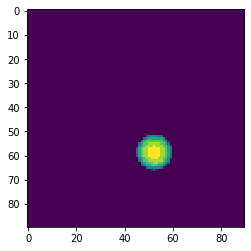

In [16]:
for ph in range(0,num_photon):
    photon_x, photon_y = rand_num_gen()
    closest_pix_x, closest_pix_y = find_closest_pix(photon_x, photon_y)
    print((closest_pix_x, closest_pix_y))
    subpix_arr, subpix_x_cen, subpix_y_cen, subpix_z_cen = integrate_setup()
    subpix_arr = sphere_integrate(subpix_x_cen, subpix_y_cen, subpix_z_cen)
    img = (np.sum(subpix_arr,axis=2))
    plt.imshow(img)
    each_pix_e(closest_pix_x, closest_pix_y)
print(np.sum(detector))

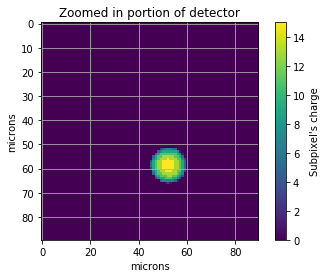

In [17]:
x_tick_img = (np.arange(0, num_pix_plt*num_subpix_x/pix_L, step = 1))
y_tick_img = (np.arange(0, num_subpix_y/pix_L, step = 1))
x_tick_img.tolist()
y_tick_img.tolist()
plt.imshow(img)
#ax.set_xticklabels(x_tick_img)
#ax.set_yticklabels(y_tick_img)
plt.xlabel('microns')
plt.ylabel('microns')
plt.title('Zoomed in portion of detector')
plt.colorbar(label="Subpixel's charge")
plt.grid()
plt.show();

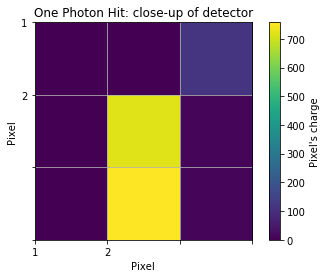

In [18]:
#zoomed in full detector: problems with actual size of plot: figure it out
x_tick_label = (np.arange(-.5, num_pix_plt))
y_tick_label = (np.arange(-.5, num_pix_plt))
x_tick_label.tolist()
y_tick_label.tolist()

num_pix_sm_det = math.ceil(num_pix_plt/2)
sm_det_arr = detector[closest_pix_x - num_pix_sm_det+1 : closest_pix_x + num_pix_sm_det, closest_pix_y - num_pix_sm_det+1 : closest_pix_y + num_pix_sm_det]
plt.imshow(sm_det_arr)
plt.grid(True)
plt.axis([0, num_pix_plt-.5, num_pix_plt-.5, 0])
plt.title('One Photon Hit: close-up of detector')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
ax = plt.gca()
ax.set_xticks(x_tick_label)
ax.set_yticks(y_tick_label)
ax.set_xticklabels(np.arange(1, num_pix_plt, 1))
ax.set_yticklabels(np.arange(1, num_pix_plt, 1))
clb = plt.colorbar()
clb.set_label("Pixel's charge")
plt.show();

In [19]:
check_tot_e = np.sum(detector) #+ bias * num_pix_x **2
if (check_tot_e == e_per_photon*num_photon):
    print('No rounding error. total number of electrons = ' + str(e_per_photon * num_photon))
else:
    print('***ROUNDING ERROR: total number of electrons is != ' + str(e_per_photon * num_photon) + ". It is = " + str(check_tot_e))

***ROUNDING ERROR: total number of electrons is != 1500000. It is = 1500000.0000000002


In [20]:
#adds the chosen bias to every value in the detector
for ii in range(num_pix_x):
    for jj in range (num_pix_y):
        detector[ii,jj] = detector[ii,jj] + bias 
#plt.imshow(detector)
#help(detector)

In [21]:
#adds gaussian noise with chosen standard deviation and mean (centroid)
noise_array = gaus_noise()
detector = detector + noise_array

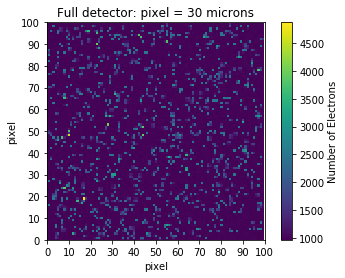

In [22]:
#to make this plot correctly we needeed to define the ticks as a LIST
x_tick_label = (np.arange(0, num_pix_x+1, step = 10))
y_tick_label = (np.arange(0, num_pix_y+1, step = 10))
x_tick_label.tolist()

plt.imshow(detector)
plt.axis([0, num_pix_plt, 0, num_pix_plt])
plt.title('Full detector: pixel = ' + str(pix_L) + ' microns')
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.colorbar(label='Number of Electrons')
#plt.axis(aspect = 'img')
ax = plt.gca()
plt.xticks(x_tick_label)
plt.yticks(y_tick_label)
plt.xlim(0,num_pix_x)
plt.ylim(0,num_pix_y)
ax.set_xticklabels(x_tick_label)
ax.set_yticklabels(y_tick_label)
plt.show();
#after converted to data number
#descretize/ digitize
#tot # of charge has to be int
#ask amy if we want to >1 or >1.4 etc
#(math.ceil)
#this is what the gain conv does!

In [23]:
if (np.sum(detector) == (e_per_photon*num_photon + bias*num_pix_x*num_pix_y)):
    print('no problem')
else:
    print('error: sum of detector did not result in expected value: actual sum of detector ' + (str(np.sum(detector))) + ' expected sum: ' + str((e_per_photon*num_photon + bias*num_pix_x*num_pix_y)) + ' + gaussian noise.')

error: sum of detector did not result in expected value: actual sum of detector 11500009.018656334 expected sum: 11500000 + gaussian noise.


In [24]:
#we need to flatten the detector bc it is a 3D array 
flat_det = detector.flatten() 
bin_div = 2.5
#***ask if this is OK? can we have different bin sizes?
num_bins = int(((bias+4*std_dev+e_per_photon) - (bias-4*std_dev)) / bin_div)
#effectively range of the detector / bin_divisor
hist, bin_edges = np.histogram(flat_det, bins=num_bins)

61.0
2500


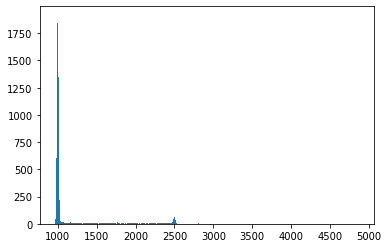

In [25]:
yhist, xhist, _ = plt.hist(flat_det, bins = num_bins)
print(max(yhist[80:]))
signal_mean = 2500 #xhist[np.where(yhist == max(yhist[100:]))]
print(signal_mean)

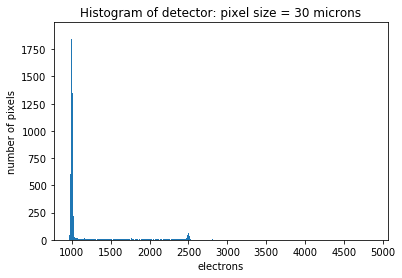

In [26]:
bin_heights, bin_boundaries, _ = plt.hist(flat_det, bins = num_bins)
plt.xlabel('electrons')
plt.ylabel('number of pixels')
plt.title('Histogram of detector: pixel size = ' + str(pix_L) + ' microns')
plt.show();

all_but_first = bin_boundaries[1:]
all_but_last = bin_boundaries[:-1]  

bin_midpoints = (all_but_first + all_but_last) / 2
#full histogram with bias and signal bumps

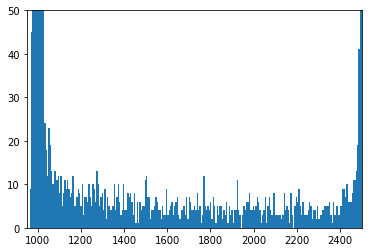

In [27]:
bin_heights, bin_boundaries, _ = plt.hist(flat_det, bins = num_bins)
plt.ylim(0, 50)
plt.xlim(950, 2500)
#plt.xlabel('electrons')
#plt.ylabel('number of pixels')
#plt.title('Histogram of detector: pixel size = ' + str(pix_L) + ' microns')
plt.show();

all_but_first = bin_boundaries[1:]
all_but_last = bin_boundaries[:-1]  

bin_midpoints = (all_but_first + all_but_last) / 2
#full histogram with bias and signal bumps

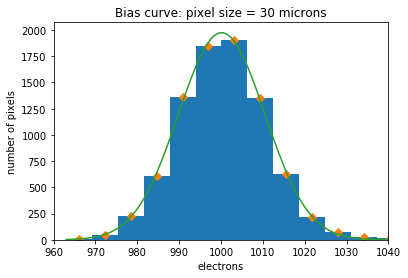

(Parameter('amplitude', value=1975.2642772816757),
 Parameter('mean', value=1000.1683146238562),
 Parameter('stddev', value=10.339966240780036, bounds=(1.1754943508222875e-38, None)))

In [28]:
# Bias fit block

gaus_guess = models.Gaussian1D(amplitude=max(hist), mean=bias, stddev=std_dev)
#print(gaus_guess)
gaus_fitter = fitting.LevMarLSQFitter()
bias_range = np.where(bin_midpoints<bias + 6 * std_dev)

fitted_gaus_bias = gaus_fitter(gaus_guess, bin_midpoints[bias_range], bin_heights[bias_range])
#print(fitted_gaus_bias)
#this works, it is returning ~ the correct answer

x_bias = np.linspace(start = np.min(bin_boundaries[bias_range]), stop = np.max(bin_boundaries[bias_range]), num = 100,)

plt.hist(flat_det, bins = num_bins)
#plt.ylim(0, 250)
plt.plot(bin_midpoints, bin_heights, "D") #this line puts the orange diamonds at the midpoint & top of every bar
plt.plot(x_bias, fitted_gaus_bias(x_bias)) #this line adds green normal curve
plt.xlim(bias-4*std_dev, bias+4*std_dev)
plt.xlabel('electrons')
plt.ylabel('number of pixels')
plt.title('Bias curve: pixel size = ' + str(pix_L) + ' microns')
plt.show();
fitted_gaus_bias.amplitude, fitted_gaus_bias.mean, fitted_gaus_bias.stddev

Text(0.5, 1.0, 'Signal curve: pixel size = 30 microns')

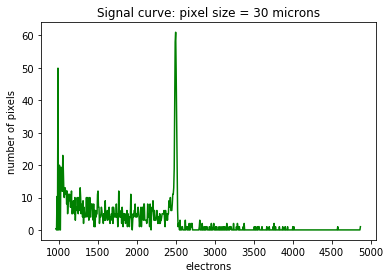

In [29]:
#where bin_heights> 0
bias_curve = fitted_gaus_bias(bin_midpoints)
bin_heights = bin_heights - bias_curve
bin_0_heights = np.where(bin_heights<0, 0, bin_heights)
#plt.plot(bin_midpoints, bin_heights)
plt.plot(bin_midpoints, bin_0_heights, color = 'green')
plt.xlabel('electrons')
plt.ylabel('number of pixels')
plt.title('Signal curve: pixel size = ' + str(pix_L) + ' microns')

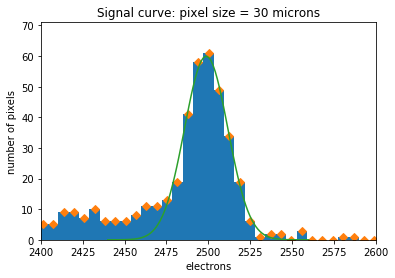

(Parameter('amplitude', value=59.935451061414014),
 Parameter('mean', value=2498.782302893482),
 Parameter('stddev', value=12.934726773071363, bounds=(1.1754943508222875e-38, None)))

In [30]:
# Signal fit block
signal_range = np.where(bias + 6 * std_dev<bin_midpoints)
gaus_guess = models.Gaussian1D(amplitude=max(hist[80:]), mean=signal_mean, stddev=std_dev)
fitted_gaus_signal = gaus_fitter(gaus_guess, bin_midpoints[signal_range], bin_heights[signal_range])
x_signal = np.linspace(start = signal_mean-std_dev*6, stop = signal_mean+std_dev*6, num = 100,)
#x_signal = np.linspace(start = np.min(signal_range), stop = np.max(signal_range), num = 100,)
plt.hist(flat_det, bins = num_bins)
#plt.ylim(0, 250)
plt.plot(bin_midpoints, bin_heights, "D") #this line puts the orange diamonds at the midpoint & top of every bar
plt.plot(x_signal, fitted_gaus_signal(x_signal)) #this line adds green normal curve
plt.xlabel('electrons')
plt.ylabel('number of pixels')
plt.title('Signal curve: pixel size = ' + str(pix_L) + ' microns')
plt.xlim(signal_mean-std_dev*10, signal_mean+std_dev*10)
plt.ylim(0,max(hist[20:])+10)
plt.show();
fitted_gaus_signal.amplitude, fitted_gaus_signal.mean, fitted_gaus_signal.stddev

In [31]:
fit_mean_bias, fit_std_dev_bias = stats.distributions.norm.fit(flat_det[bias-4*std_dev : bias+4*std_dev])
print(fit_mean_bias)
print(fit_std_dev_bias)
#these numbers represent the centroid of the "bias bump"
#the slice should be from bias - 4*std_dev to bias+4*std_dev

1105.9831122478774
354.5191076390824


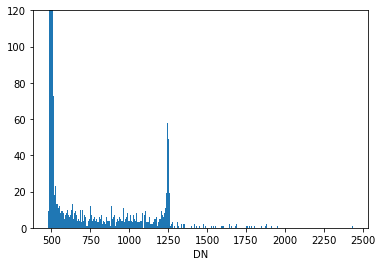

In [32]:
plt.hist(flat_det/gain, bins = num_bins)
plt.ylim(0, 120)
plt.xlabel('DN')
#plt.legend()
#plt.grid(True)
plt.show();
#we can get gain from this

In [33]:
if (np.sum(detector) == (e_per_photon*num_photon + bias*num_pix_x*num_pix_y)/gain):
    print('no problem')
else:
    print('error: sum of detector did not result in expected value: actual sum of detector ' + (str(np.sum(detector))) + 'expected sum: ' + str((e_per_photon*num_photon + bias*num_pix_x*num_pix_y)/gain))

error: sum of detector did not result in expected value: actual sum of detector 11500009.018656334expected sum: 5750000.0


In [34]:
#the pix_L to e_cloud ratio makes the peak at lower charge
#how much lower is this peak?? how much less is the centroid charge